In [3]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [4]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, MultiPolygon, Polygon
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
import numpy as np
import time

SQLalchemy is not installed. No support for SQL output.


In [5]:
# import helper functions 
# imports all helper functions stored in class "helpers" 
%run -i helperFunctions.py

# Create zones and add basic information
## Zones Berliner Ortsteile, number of inhabitants 
Uses Berliner Ortsteile (n=98), source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_alkis_ortsteile

Population data on bulding block level 2020, source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s06_06ewdichte2020

In [6]:
input_path = './../../input/zones/'
output_path = './../../output/'
model_path = './../../model/'

### read in Berliner Ortsteile shapefile

In [7]:
# Load the model with LoS tables from the last exercise
sm = stepmodel.read_json(model_path + 'los_tables')

In [8]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("GeoDataFrames that could not be fixed:", broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters']
Successfully fixed.


,uuid,sch,nam,gdf,bezeich,geometry
index,,,,,,
zone_54,DEBE12YYJ0000007,110000121207,Waidmannslust,2232857.0,AX_KommunalesGebiet,"POLYGON ((13.33156 52.61449, 13.33216 52.61408..."
zone_61,DEBE07YY90000009,110000070701,Schöneberg,10642847.0,AX_KommunalesGebiet,"POLYGON ((13.35133 52.50257, 13.35139 52.50255..."


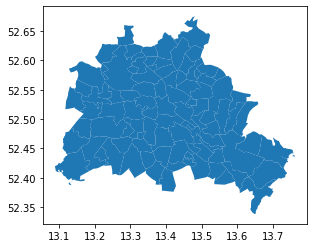

In [9]:
sm.zones.plot()
sm.zones.sample(2)

### read and clean in building block shapefile

In [10]:
# Add building block shapefile
buildings = gpd.read_file(input_path + "Einwohnerdichte_2020.shp")
buildings.to_crs(epsg=4326, inplace=True)
# remove buildings without geometry property
print("removing", sum(buildings.geometry == None), 
      "buildings with",
      round(sum(buildings[buildings.geometry == None]["ew2020"])),
      "inhabitants due to lack of geometry, e.g. building with schl5 =",
     buildings[buildings.geometry == None].iloc[0]["schl5"])
buildings = buildings[buildings.geometry != None]
buildings["zone"] = None

removing 127 buildings with 4863 inhabitants due to lack of geometry, e.g. building with schl5 = None


In [11]:
buildings.head(2)

,schl5,ew2020,flalle,ew_ha_2020,typklar,area_calc,geometry,zone
0,0100980011000100,3.0,4624.0,6.487889,Freie Zeilenbebauung mit landschaftlichem Sied...,4623.945832,"POLYGON ((13.36830 52.53464, 13.36857 52.53475...",None
1,0100980011000300,21.0,5604.0,37.473233,Geschosswohnungsbau der 1990er Jahre und jünger,5603.674449,"POLYGON ((13.36732 52.53556, 13.36693 52.53592...",None


<AxesSubplot:>

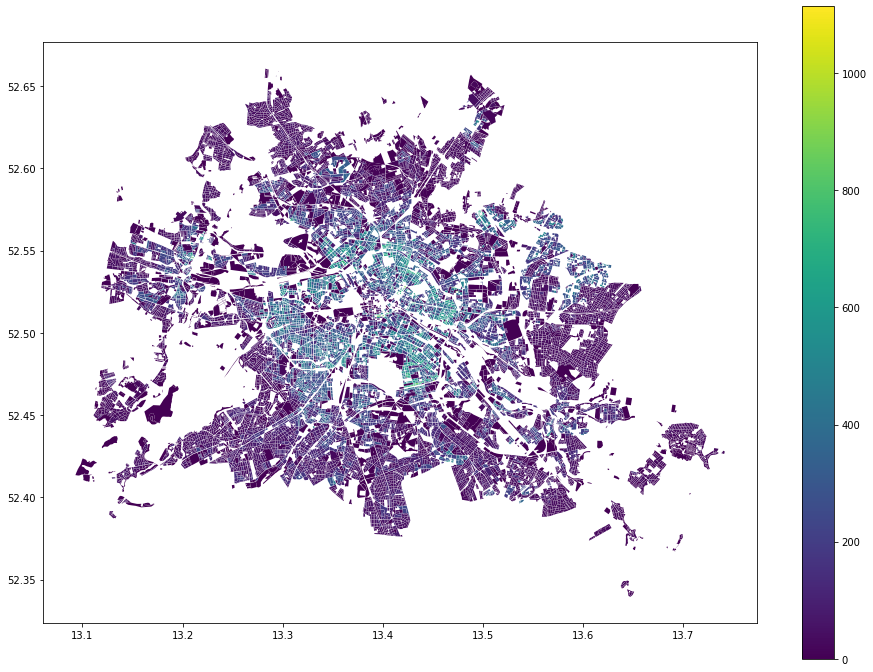

In [12]:
fig, ax = plt.subplots(figsize = (16,12))
buildings.plot(ax=ax, column='ew_ha_2020', cmap = "viridis", legend=True)

### assign a zone to each building

In [13]:
t0=time.time()
# assign zone to each building
buildings["zone"] = \
    buildings['geometry']\
        .apply(lambda g: sm.zones.index[sm.zones.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)


Text(0.5, 1.0, 'Assignment of buildings to zones')

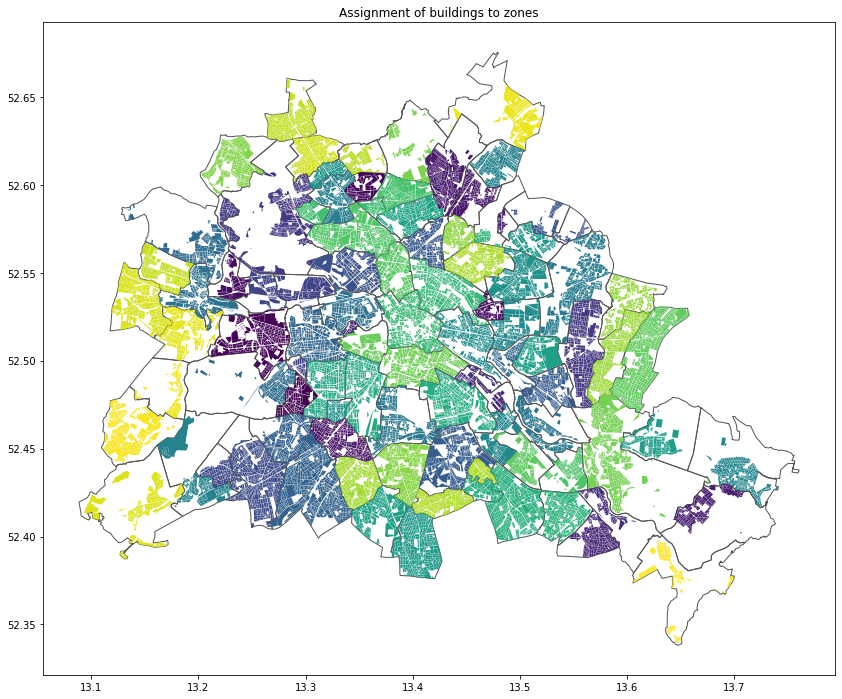

In [14]:
# plot
fig, ax = plt.subplots(figsize = (16,12))
sm.zones.plot(ax=ax, color="#ffffff00", edgecolor="#555")
buildings.plot(ax=ax, column='zone', cmap = "viridis", legend=False)
ax.set_title("Assignment of buildings to zones")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:19. Minutes remaining: 00:00. 

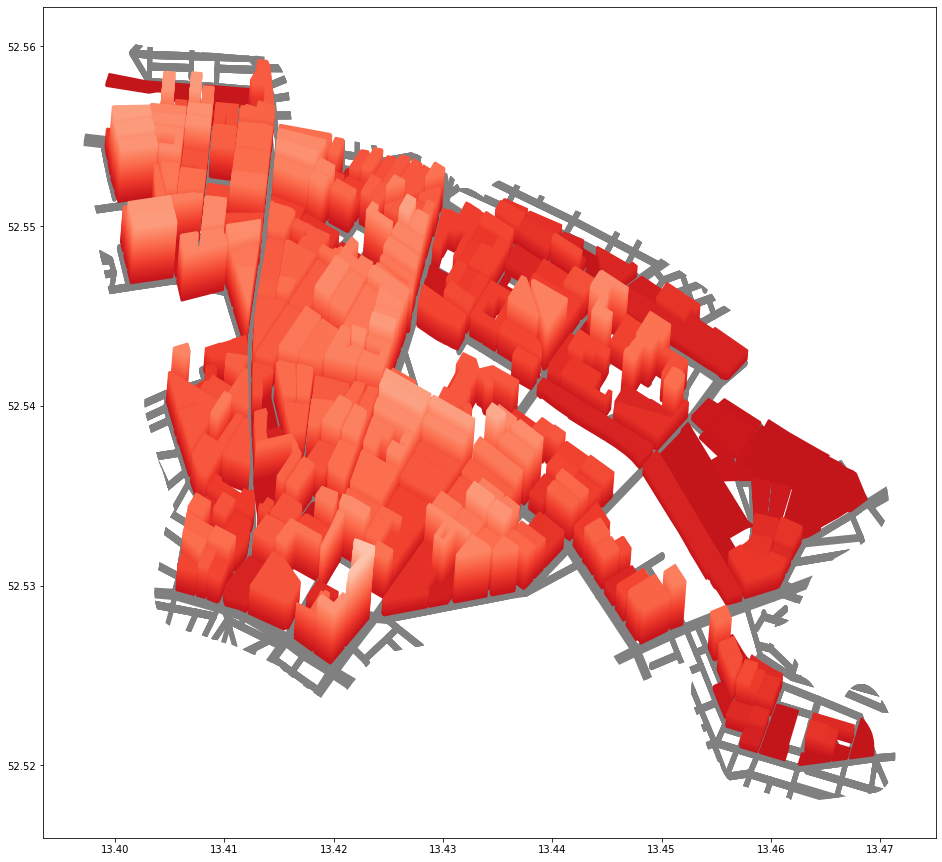

In [43]:
# some map art

from shapely.affinity import translate
from shapely.ops import unary_union
import time
sf = ["Prenzlauer Berg"]#["Pankow", "Prenzlauer Berg", "Mitte"]
spb = buildings[buildings["zone"].isin(sm.zones.index[sm.zones["nam"].isin(sf)])]
bspb = unary_union(list(spb.geometry.apply(lambda g: g.buffer(0.002))))
bspb = Polygon(bspb.exterior.coords)

fig, ax = plt.subplots(figsize = (16,16))
t0 = time.time()

sm.road_links.geometry[list(sm.road_links.intersects(bspb))].apply(lambda g: g.buffer(0.00022).intersection(bspb)).plot(ax=ax, color ="grey")


maxHeight = max(spb["ew_ha_2020"])

nSteps = 50
cbuff = 40
cmap = plt.get_cmap('Reds_r', nSteps + cbuff)

for i in range(0,nSteps):
    # spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 1,8) if (row["ew_ha_2020"] >= i/nSteps*maxHeight) else None, axis = 1)
    spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 0.00001,0.00008) if (row["ew_ha_2020"] >= i/nSteps*maxHeight) else None, axis = 1)
    spb.plot(ax=ax, color = cmap(round(i + 0.5*cbuff)), edgecolor = cmap(round(i + 0.5*cbuff)), linewidth = 2)
    # spb.plot(ax=ax, column='ew_ha_2020', cmap = "viridis", linewidth = 2)
    helpers.printProgress(i=i, imax=nSteps, t=time.time(), t0=t0)





### for each zone: sum up population from buildings and create centroids weighted by population

popCentroid (13.228250106615496, 52.580581987471035) not within polygon for zone zone_24 Konradshöhe


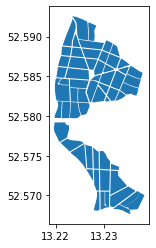

In [51]:
t0=time.time()
# sum up population from buildings to each zone and create centroids weighted by population
sm.zones["pop"] = 0
sm.zones["popCentroid"] = Point(0,0)
sm.zones["popCentroidOffset"] = LineString([Point(0,0), Point(0,0)])
sm.zones["popCentroidLat"] = 0.0
sm.zones["popCentroidLon"] = 0.0

for zoneIndex, zone in sm.zones.iterrows():
    buildingsInZone = buildings[buildings["zone"]==zoneIndex]
    
    # obtain total zone population and save to sm.zones
    zonePopulation2020 = sum(buildingsInZone["ew2020"])
    sm.zones.at[zoneIndex, "pop"] = zonePopulation2020
    
    # create weighted centroids based on where most people live within 
    weigthedCoords = {"lat": 0, "lon": 0}
    for buildingIndex, building in buildingsInZone.iterrows():
        weigthedCoords["lon"] += building["ew2020"] / zonePopulation2020 * building["geometry"].centroid.x
        weigthedCoords["lat"] += building["ew2020"] / zonePopulation2020 * building["geometry"].centroid.y
    
    sm.zones.at[zoneIndex, "popCentroidLat"] = weigthedCoords["lat"]
    sm.zones.at[zoneIndex, "popCentroidLon"] = weigthedCoords["lon"]
    popCentroid = Point(weigthedCoords["lon"], weigthedCoords["lat"])
    
    # check whether those centroids which are not within zone are still plausible
    if(not popCentroid.intersects(zone["geometry"])):
        print("popCentroid", popCentroid.coords[0], "not within polygon", "for zone", zoneIndex, zone["nam"])
        buildingsInZone.plot()
    
    sm.zones.loc[zoneIndex, "popCentroid"] = popCentroid
    # add a line between actual centroid and pop centroid
    sm.zones.loc[zoneIndex, "popCentroidOffset"] = LineString([zone["geometry"].centroid, popCentroid])
    # helpers.printProgress(i=zoneIndex, imax=len(sm.zones), t=time.time(), t0=t0)

Text(0.5, 1.0, 'Zones centroids vs population weigthed centroids')

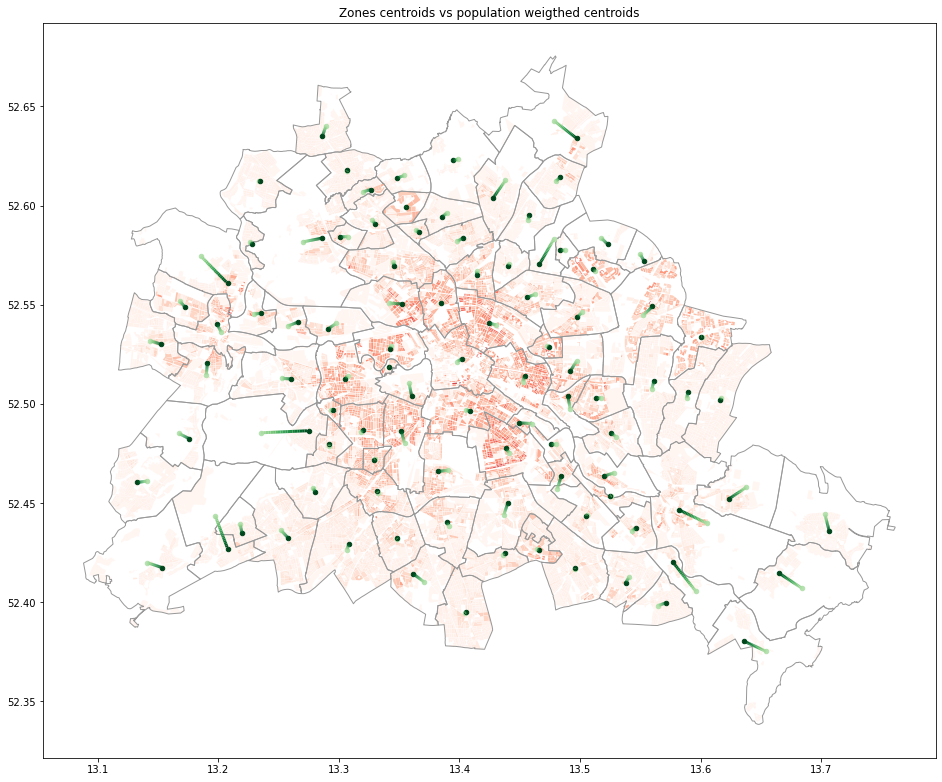

In [52]:
# show zones and popCentroids and their offsets from real geometrical centroids
fig, ax = plt.subplots(1, 1, figsize=(16,16))
buildings.plot(ax=ax, column='ew_ha_2020', cmap = "Reds")
# add zone borders and a bit of opacity
sm.zones.geometry.plot(ax=ax, color = "#ffffff33", edgecolor="#999999")
nSteps = 20
cbuff = 10
cmap = plt.get_cmap('Greens_r', nSteps + cbuff)
gpd.GeoSeries(sm.zones.geometry.centroid, crs=sm.epsg).plot(ax=ax, color = cmap(nSteps), markersize = 20)
for i in range(1,nSteps):
    l = list(map(lambda x: helpers.segmentLine(x, i, nSteps), sm.zones.popCentroidOffset))
    gpd.GeoSeries(l, crs=sm.epsg).plot(ax=ax,color=cmap(i), linewidth=3)
gpd.GeoSeries(sm.zones.popCentroid, crs=sm.epsg).plot(ax=ax, color = cmap(0), markersize = 20)
ax.set_title("Zones centroids vs population weigthed centroids")

<AxesSubplot:>

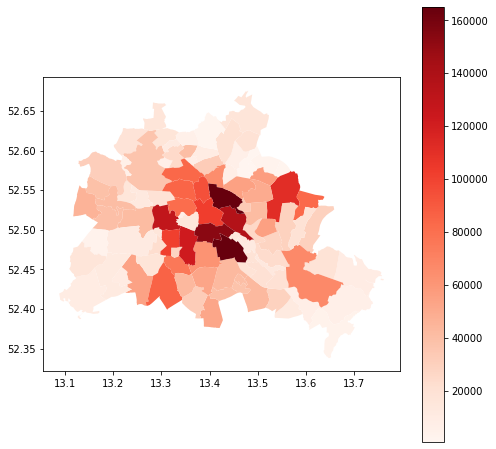

In [53]:
# plot population by zone
sm.zones.plot(column='pop', cmap = "Reds", legend=True, figsize = (8,8))

<AxesSubplot:>

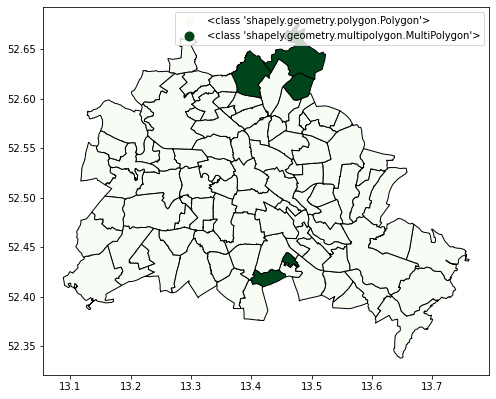

In [54]:
# plot zones by geometry type
sm.zones.plot(column = np.array(list(map(lambda x: type(x), sm.zones["geometry"]))),  cmap = "Greens",  edgecolor="black", legend=True, figsize = (8,8))

### Next steps. Create attractor estimation.

Create attractor fields. <br>
Use school locations. (shapefile already there) <br>
Use Business locations (look up via OSM) <br>
Use Shopping locations (look up via OSM) <br>
Maybe use other data source like traffic data? <br>
Maybe use building height? <br>
Get Data on Mode Choice / Car Ownership for each zone? <br>

## Save model

In [57]:
sm.zones

,uuid,sch,nam,gdf,bezeich,geometry,pop,popCentroid,popCentroidOffset,popCentroidLat,popCentroidLon
index,,,,,,,,,,,
zone_0,DEBE04YY5000000B,110000040403,Schmargendorf,3588120.0,AX_KommunalesGebiet,"POLYGON ((13.29468 52.49183, 13.29469 52.49183...",22733,POINT (13.29189444790202 52.47988999273223),LINESTRING (13.29194210876242 52.4787347196139...,52.479890,13.291894
zone_1,DEBE04YY50000001,110000040405,Westend,13527378.0,AX_KommunalesGebiet,"POLYGON ((13.28118 52.53049, 13.28180 52.53028...",41313,POINT (13.26024006958378 52.51251034920081),LINESTRING (13.25263254078428 52.5128707387354...,52.512510,13.260240
zone_2,DEBE01YYK0000001,110000010103,Hansaviertel,528303.0,AX_KommunalesGebiet,"POLYGON ((13.34537 52.52250, 13.34547 52.52248...",5725,POINT (13.34137724836114 52.51861241085735),LINESTRING (13.34179166187051 52.5185423480625...,52.518612,13.341377
zone_3,DEBE11YYH0000001,110000111104,Falkenberg,3053073.0,AX_KommunalesGebiet,"POLYGON ((13.56659 52.57332, 13.56625 52.57309...",2091,POINT (13.55281290783514 52.57216655503397),LINESTRING (13.54965718249925 52.5757535220523...,52.572167,13.552813
zone_4,DEBE04YY5000000D,110000040404,Grunewald,22354409.0,AX_KommunalesGebiet,"POLYGON ((13.25461 52.50345, 13.25366 52.50271...",11172,POINT (13.27556581175098 52.48642853815884),LINESTRING (13.23550986475725 52.4853708230216...,52.486429,13.275566
...,...,...,...,...,...,...,...,...,...,...,...
zone_92,DEBE05YYQ0000003,110000050509,Wilhelmstadt,10421573.0,AX_KommunalesGebiet,"POLYGON ((13.17876 52.53063, 13.17879 52.53063...",39286,POINT (13.19099474022487 52.52038724940491),LINESTRING (13.19011406006874 52.5145488906105...,52.520387,13.190995
zone_93,DEBE03YY6000000D,110000030309,Buch,631.0,AX_KommunalesGebiet,"MULTIPOLYGON (((13.50544 52.61969, 13.50506 52...",16470,POINT (13.49721566724014 52.63387150648175),LINESTRING (13.47856309531416 52.6427136219358...,52.633872,13.497216
zone_94,DEBE05YYQ000000F,110000050505,Gatow,10112629.0,AX_KommunalesGebiet,"POLYGON ((13.18715 52.48713, 13.18981 52.48433...",3463,POINT (13.17617453199097 52.48232847387915),LINESTRING (13.16722205978271 52.4850771916957...,52.482328,13.176175


In [59]:
sm.zones.dtypes

uuid                   object
sch                    object
nam                    object
gdf                   float64
bezeich                object
geometry             geometry
pop                     int64
popCentroid            object
popCentroidOffset      object
popCentroidLat        float64
popCentroidLon        float64
dtype: object

In [58]:
sm.zones.columns[list(sm.zones.dtypes == "geometry")]

Index(['geometry'], dtype='object')

In [56]:
# remove additional geometry from dataframe, as otherwise an error is thrown when saving. 
geomCols = sm.zones.columns[list(sm.zones.dtypes == "geometry")]
# drop all geom columns except the main one named "geometry"
sm.zones = sm.zones.drop(columns = geomCols[geomCols != "geometry"])

In [49]:
# Saving model zones as geojson
sm.to_json(model_path + 'ber_zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting):  66%|██████▌   | 25/38 [00:02<00:01,  9.23it/s]


OverflowError: Maximum recursion level reached